# ILV04 Interpreting Learning Curves
A concise lecture that aims to help you learn how to evaluate the training progress of your machine learning models.

## ILV04.0 a) Learning Objectives

In today's lesson we are going to answer following questions:

- How do we evaluate the quality of the model we just trained?
- What does bias & variance have to do with this?
- How do we identify overfitting & underfitting?
- What type of tools do we have at our disposal to achieve this?
- How do we use the gained knowledge to train and evaluate our model the correct way?

## ILV04.0 b) Recap

Before we train a new model, let's recap the simple perceptron we trained in LB03.

#### Sample Data:
First, let's have a look at the training data that was used.

| $x_1$ | $x_2$ | $y$ |
| :-: | :-: | :-: |
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

#### Simple Perceptron:
Next up, we are going to take a look at the model's archicture.<br>
Remember, this is the simple perceptron we implemented ourselves.
<center><img src="resources/ILV04_perceptron_architecture.png" style="width:75%"/></center>

#### Learning Curve (epochs=1000, lr=1):

<div style="width: 45%; float: left;">
    <img src="resources/ILV04_perceptron_training_loss.png"/>
</div>

<div style="width: 55%; float: left; margin-top:50px">
    <ul>
        <li>What is this curve telling us?</li>
        <li>Based on this curve, is it possible to determine if the model accurately learned the general model of the data?</li>
    </ul>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras import callbacks
import os

Using TensorFlow backend.


In [2]:
# Function that returns a sequential Keras model, similar to the code you used in LB03.3 a)
def create_model(input_dim = None, output_dim = None, hidden_nodes = None):
    model = Sequential()
    model.add(Dense(hidden_nodes, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    
    loss_function = "binary_crossentropy"
    optimizer = "adam"

    model.compile(loss=loss_function, optimizer=optimizer, metrics=["accuracy"])
    return model

In [3]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# we adapted the code to introduce our own scoring (using binary-crossentropy loss) specifically for keras models

def custom_learning_curve(model, X, y, n_folds = 10, train_sizes = np.linspace(0.1, 1, 10)):
    """
    Learning curve.
    Determines cross-validated training and test scores for different training
    set sizes.
    
    A cross-validation generator splits the whole dataset k times in training
    and test data. Subsets of the training set with varying sizes will be used
    to train the estimator and a score for each training subset size and the
    test set will be computed. Afterwards, the scores will be averaged over
    all k runs for each training subset size.
    
    Returns (adapted by reufko & mschirl):
    -------
    train_counts : array of shape (train_sizes,) holding the average number of samples used to train the model

    train_losses : array of shape (n_folds, train_sizes) holding the train losses computed for each fold and train_size

    valid_losses : array of shape (n_folds, train_sizes) holding the validation losses computed for each fold and train_size 
    """
    
    model.save_weights('initial_weights.h5')
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=None)
    train_losses = []
    valid_losses = []
    train_counts = []
    
    for train, valid in kfold.split(X, y):
        train_loss = []
        valid_loss = []
        train_count = []
        for percentage in train_sizes:
            if percentage == 1.0:
                X_train, y_train = (X.iloc[train, :], y[train])
            else:
                X_train, X_test, y_train, y_test = train_test_split(X.iloc[train, :], y[train], test_size=1-percentage, random_state = None)
            history = model.fit(X_train, y_train, epochs=200, verbose=0)
            train_loss.append(model.evaluate(X_train, y_train, verbose=0)[0])
            valid_loss.append(model.evaluate(X.iloc[valid, :], y[valid], verbose=0)[0])
            model.load_weights('initial_weights.h5')
            train_count.append(X_train.shape[0])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_counts.append(train_count)
    os.remove("initial_weights.h5")
    return np.array(train_counts).T.mean(axis=1), np.array(train_losses).T, np.array(valid_losses).T

In [4]:
# This function returns the index of an epoch where early stopping (based patience and epsilon) should be performed.
def get_early_stopping_index(history, patience=5, epsi = 0.0001):
  counter = 0
  max_loss = np.array(history["val_loss"]).max()
  i=0

  for index, row in enumerate(history["val_loss"]):
    if(counter==patience):
      break

    if(row<max_loss-epsi):
      i=index
      max_loss=row
      counter = 0
    else:
      counter+=1
      
  return i

In [5]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring=None, title=""):
    # Function taken from
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Loss")
    train_sizes, train_scores, test_scores = custom_learning_curve(estimator, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training loss")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation loss")

    plt.legend(loc="best")
    return plt

In [6]:
# Simple function that plots loss over epochs and accuracy over epochs (for both train and validation set).
# Also adds a marker for the epoch, where early stopping should be performed if the appropriate index is passed
def plot_learning_curve_over_epochs(history = None, early_stopping = None):
    fig = plt.figure(figsize=(12, 10), dpi=80)
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    plt.show()

In [7]:
# Adapted from LB02.5 b)
def select_features_above_threshold(threshold = 0.9, corr_matrix = None):
    # Make values in the correlation matrix absolute
    corr_matrix = corr_matrix.abs()

    # Select upper triangle of correlation matrix
    triangle_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
    upper_triangle = corr_matrix.where(triangle_mask)

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    return to_drop

In [8]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 10))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3, out=None)  
    
    
    thresh = cm.max() / 2.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## ILV04.1 Training, Validating and Testing

In LB03, we considered the testing dataset to be equal to the training dataset.

| $x_1$ | $x_2$ | $y$ |
| :-: | :-: | :-: |
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

However, to fully evaluate machine learning models, you need three separate datasets.<br>
We are going to need a more complex dataset if we want to do this split properly.

In [9]:
df = pd.read_csv('datasets/breast_cancer.csv', sep=';')

In [10]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### ILV04.1 a) Set aside a Held-out Test Set

Note: Direct quotations in this section are taken from ["Deep Learning", Goodfellow et al., 2016; Section 5.3](https://www.deeplearningbook.org/contents/ml.html).

"We discussed how a held-out test set, composed of examples coming from the same distribution as the training set, can be used to estimate the generalization error of a learner, after the learning process has completed." 

"It is important that the test examples **are not used in any way to make choices about the model**, including its hyperparameters."

### Label Encoding

In [12]:
y = df['diagnosis']
y = [1 if label == 'malignant' else 0 for label in y]
y = np.array(y)
X = df.drop(columns=['diagnosis'])

### Stratified Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify = y)

### Train and Test Data After Split

In [14]:
cols_to_display = [
    "mean radius", 
    "mean texture",
    "mean area",
    "mean smoothness"
]
random_indices = np.random.randint(X_train.shape[0], size=5)
indices = X_train.index[random_indices]
X_train.loc[indices, cols_to_display]

,mean radius,mean texture,mean area,mean smoothness
90,14.62,24.02,662.7,0.08974
131,15.46,19.48,748.9,0.10920
183,11.41,14.92,402.0,0.09059
517,19.89,20.26,1214.0,0.10370
552,12.77,29.43,507.9,0.08276


In [15]:
pd.Series(y_train, index=X_train.index)[indices]

42     0
279    1
221    1
515    1
323    0
dtype: int64

In [16]:
X_test[cols_to_display].sample(5)

,mean radius,mean texture,mean area,mean smoothness
553,9.333,21.94,264.0,0.09240
121,18.660,17.12,1077.0,0.10540
260,20.310,27.06,1288.0,0.10000
246,13.200,17.43,541.6,0.07215
428,11.130,16.62,381.1,0.08151


### ILV04.1 b) Validation
By leaving the test set out of the learning process and the process of tuning hyperparameters, we need an additional set that helps us to evaluate the performance of the model during training.

"In order to create a subset of the data, which will help us tune the hyperparameters of the model, we need to split the **training set** into a training and validation set."

You may use different strategies to implement this, two are listed in the following slides.




**Holdout**:

- Setting aside a validation set by splitting the train set again
- This results in a fixed train set and a fixed validation set
- Be careful to NEVER use the test set as your validation dataset!
- In Keras: use fit() method of a Keras Model with either `validation_split=percentage` or `validation_data=valid_dataset`.

<center><img src="resources/ILV04_train_test_val_split.png" style="width: 80%;"/></center>

**Cross-Validation:**

- "Dividing the dataset into a ﬁxed training set and a ﬁxed validation set can be problematic if it results in the validation set being small. A small validation set implies statistical uncertainty around the estimated average validation error, making it difficult to claim that algorithm $A$ works better than algorithm $B$ on the given task."

- "When the dataset has hundreds of thousands of examples or more, this is not a serious issue. When the dataset is too small, alternative procedures enable one to use all the examples in the estimation of the mean validation error, at the price of increased computational cost."

- "The most common of these is the k-fold cross-validation procedure, in which a partition of the dataset is formed by splitting it into k nonoverlapping subsets. The image bellow illustrates this procedure."


<center><img src="resources/ILV04_k-fold-cross-validation-method.png" style="width: 75%;"/></center>
<center><a href="https://www.researchgate.net/publication/331209203_Tectonic_discrimination_of_olivine_in_basalt_using_data_mining_techniques_based_on_major_elements_a_comparative_study_from_multiple_perspectives">"Tectonic discrimination of olivine in basalt using data mining techniques based on major elements: a comparative study from multiple perspectives", Ren et al, 2019</a></center>

## ILV04.2 Bias & Variance, Overfitting & Underfitting

<center><img src="resources/ILV04_problem_space.png" style="width: 60%;"/></center>

<center>S. Wegenkittl, Lecture on Machine Learning: Slide 15</center>


### ILV04.2 a) Explaining Variance and Bias in Statistical Learning Theory
Note: Direct quotations in this subsection are taken from ["An Introduction to Statistical Learning", James et al., 2013; Section 2.2](https://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf).

"**Variance** refers to the amount by which $\hat{f}$ would change if we estimated it using a different training data set. Since the training data are used to fit the statistical learning method, different training data sets will result in a different $\hat{f}$. But ideally the estimate for $f$ should not vary too much between training sets. However, if a method has high variance then small changes in the training data can result in large changes in $\hat{f}$. In general, more flexible statistical methods have higher variance."

"**Bias** refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a much simpler model. For example, linear regression assumes that there is a linear relationship between $Y$ and $X_1, X_2, ..., X_p$. It is unlikely that any real-life problem truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate off."

<div style="width: 40%; float: left; margin-right:25px">
    <img src="resources/ILV04_bias_variance.png"/>
    <center><a href="https://medium.com/@akgone38/what-the-heck-bias-variance-tradeoff-is-fe4681c0e71b">medium.com</a></center>
</div>

<div style="width: 55%; float: left; margin-top:150px">
    Match the targets A, B, C, D to the following statements:
    <br>
    <ol>
        <li>Skewed mean error - High bias, high variance</li>
        <li>Constantly skewed - High bias, low variance</li>
        <li>Mean error comes close to target - Low bias, low variance</li>
        <li>Mean error comes close to target - Low bias, high variance</li>
    </ol>
</div>

### ILV04.2 b) What is Overfitting and Underfitting?

<center><img src="resources/ILV04_overfitting_underfitting.png" style="width: 70%"/></center>

<center><a href="https://www.deeplearningbook.org/">"Deep Learning", Goodfellow et al., 2016; Section 5.2</a></center>


- "**Underfitting** occurs when the model is not able to obtain a sufficiently low error value on the training set."

- "**Overﬁtting** occurs when the gap between the training error and validation error is too large."

### ILV04.2 c) Relationship Between Variance & Bias and Overfitting & Underfitting



<center><img src="resources/ILV04_relationship_underover_biasvariance.png" style="width: 70%"/></center>
<center><a href="https://www.deeplearningbook.org/">"Deep Learning", Goodfellow et al., 2016; Section 5.4</a></center>

- **Overfitting**: low bias, high variance

- **Underfitting**: low variance, high bias

### Bonus Question:

Now that we learned more about the terms variance, bias as well as overfitting and underfitting,<br>let's revisit the first slide of this section and ask ourselves:
- How would overfitting look like if drawn onto this diagram? 
- What about underfitting?


<center><img src="resources/ILV04_problem_space.png" style="width: 60%;"/></center>

<center>S. Wegenkittl, Lecture on Machine Learning: Slide 15</center>


## ILV04.3 Learning Curves

With the knowledge we acquired so far, we are now able to talk about two different learning curves that help us to evaluate a model's training success.

We are going to take a look at a curve displaying loss and validation loss over the number of training samples as well as loss and validation loss over the training epochs.

### Trivia (from ["Learning Curves in Machine Learning", Perlich, 2009](https://www.researchgate.net/publication/247934703_Learning_Curves_in_Machine_Learning))


<center><img src="resources/ILV04_ebbinghaus.jpg" style="width: 20%; margin-top:50px"/></center>
<center><a href="https://en.wikipedia.org/wiki/Hermann_Ebbinghaus">Hermann Ebbinghaus</a></center>

Learning curves were initially introduced in educational and behavioral/cognitive psychology. The ﬁrst person to describe the learning curve was Hermann Ebbinghaus in **1885**. He found that the time required to memorize a non-sense syllable increased sharply as the number of syllables increased.


### ILV4.3 a) Number of Samples

Note: The following subsection is adapted from [Andrew Ng's video](https://www.youtube.com/watch?v=ISBGFY-gBug) about learning curves.


Lets imagine the following setup, we have a data set which is being deliberately reduced in terms of training samples. 

In the image bellow you can see the 6 diagrams which contain 1 to 6 samples of the training set. 
We will try to fit a quadratic function $h_{\theta}(x)$ on each of those training sets.


<div style="width: 40%; float: left; margin-right:25px">
    <img src="resources/ILV04_training_sets_1-6.png"/>
</div>

<div style="width: 55%; float: left; margin-top:150px">
   $\large h_{\theta}(x) = \theta_0 + \theta_1x + \theta_2x^2$
</div>


As you can see the first few diagrams, 1 to 3 training samples to be precise, are showing that it is possible to fit a quadratic function to the given training samples. Therefore the training error on a small subset of the training data is usually very small. As the subset of the training data is getting larger, the training error is getting bigger, because it is not possible to fit the quadratic function to the given data points, as you can see on the diagrams with 4-6 training samples.

Now lets take a look on the training curves. We will use the mean squared error for this example and define the functions $J_{train}(\theta)$ which describes the training error and $J_{cv}(\theta)$ which is the cross validation error.

<center>$\large J_{train}(\theta)=\frac{1}{2m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^2$</center>

<center>$\large J_{cv}(\theta)=\frac{1}{2m_{cv}} \sum_{i=1}^{m} (h_{\theta}(x_{cv}^{(i)}) - y_{cv}^{(i)})^2$</center>

Since in the begining it is very easy for the classifier to fit its quadratic function to a small subset of the training data the training error is very small. The other subset of the data called validation data is usually not going to fit the same function, since the classifier only has insight to the training data. Therefore the validation error is going to be bigger when the training set is small. This is shown in the diagram bellow.
<img src="resources/ILV04_learning_curve_sample.png" style="width: 40%; "/>

**High bias**

Now lets imagine we have a hypothesis which is described as a straight line $h_{\theta}(x)$ and we are trying to fit this line to the following data.

<div style="width: 40%; float: left; margin-right:25px; margin-top: 20px;">
    <img src="resources/ILV04_high_bias_sample_data.png"/>
</div>

<div style="width: 55%; float: left; margin-top:40px;">
   $\large h_{\theta}(x) = \theta_0 + \theta_1x$
</div>

Getting more data doesn't really change the line you already fitted.

When we plot the training and cross validation error for this case we can see following. Cross validation error is high in the beginning and it stays high even with a much larger training set. 
Training error is small in the beginning but it gets higher as soon as the training sizes increases.
<img src="resources/ILV04_high_bias_curve_sample.png" style="width: 40%; "/>

So what does this tell us about our model?

Getting more data is not going to help us solving this problem. We should try to tune another hyperparameters, such as:
- input dimensions, 
- number of hidden nodes, 
- number of hidden layers etc.

**High variance**

Lets say we have the following data and we are fitting a high order polynomial $h_{\theta}(x)$ on this data. Here we will use a 100-degree polynomial, which is actually only used for the sake of this illustration.

<div style="width: 40%; float: left; margin-right:25px; margin-top: 20px;">
    <img src="resources/ILV04_high_variance_sample_data.png"/>
</div>

<div style="width: 55%; float: left; margin-top:40px;">
   $\large h_{\theta}(x) = \theta_0 + \theta_1x + ... +  \theta_{100}x^{100}$
</div>

As you can see, this will fit the data fairly well.

Plotting the error curves for the training and cross validation error shows following. The training error is increasing slightly as the training set size increases. The cross validation error decreases steadily as the training set size increases. 
<img src="resources/ILV04_high_variance_curve_sample.png" style="width: 40%; "/>

This leaves us with a pretty big error gap between the cross validation error and train error. 

What is this type of learning curve telling us regarding our model? 

In this case, getting more data is likely to help. 

If we consider that the training error increases and the cross validation error decreases and extrapolate this diagram to the right, we can see that this could help improving the model.

<img src="resources/ILV04_high_variance_curve_sample_long.png" style="width: 40%; "/>

### Plotting Loss over Training Samples for our Model

First, let's create our model using the `create_model` function.

In [17]:
model = create_model(input_dim=X_train.shape[1],
                     output_dim=1,
                     hidden_nodes=10)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

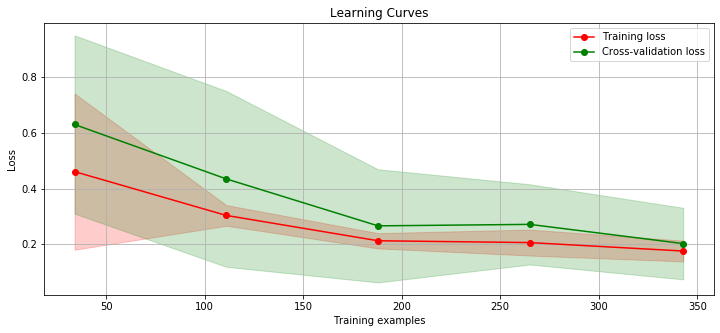

In [18]:
plot_learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 5), title="Learning Curves")

### ILV04.3 b) Number of Training Iterations

To show you this type of learning curve, we are going to take a look at code producing curves like this.<br>If you want a more detailed explanation, you can take a look at this [blog](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

In [19]:
model = create_model(input_dim=X_train.shape[1],
                     output_dim=1,
                     hidden_nodes=10)

history = model.fit(X_train, y_train, validation_split = 0.33, 
                    verbose=0, epochs=200, batch_size=32)

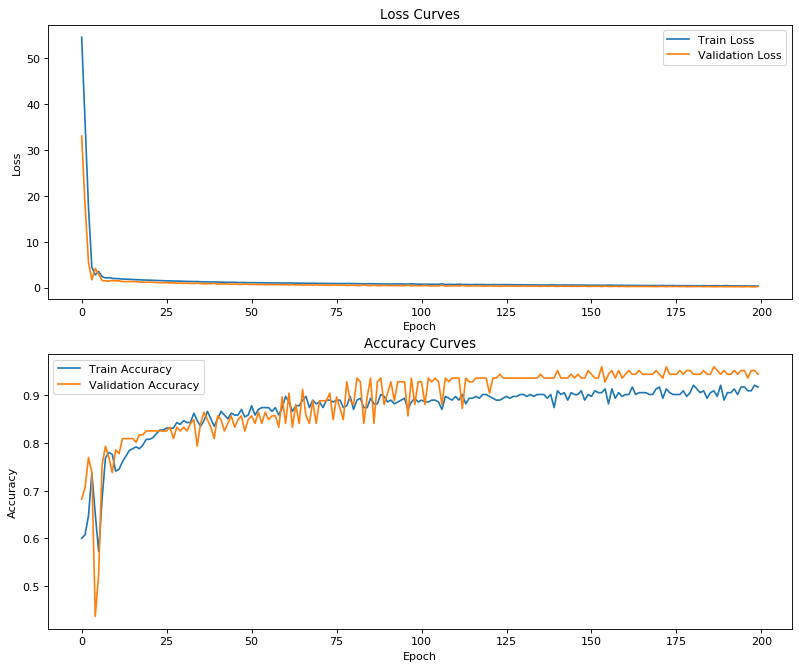

In [20]:
plot_learning_curve_over_epochs(history)

### ILV04.3 c) Combining the Two Types of Learning Curves
We are now going to train a simpler version of the model by reducing the input dimensionality of the dataset as well as using fewer hidden nodes. This different model configuration will also produce different learning curves for you to evaluate.

In [15]:
# Select a subset of features to drop in order to create a simpler model
corr_matrix = X_train.corr()
to_drop = select_features_above_threshold(0.80, corr_matrix=corr_matrix)

X_train_sel = X_train.drop(columns=to_drop)
X_test_sel = X_test.drop(columns=to_drop)

In [22]:
# Create the model again with fewer input dimensions and fewer hidden nodes
model = create_model(input_dim=X_train_sel.shape[1],
                     output_dim=1,
                     hidden_nodes=5)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

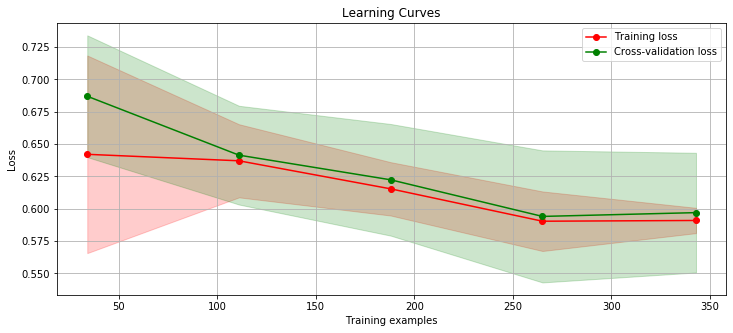

In [23]:
plot_learning_curve(model, X_train_sel, y_train, train_sizes=np.linspace(0.1, 1, 5), title="Learning Curves")

In [25]:
model = create_model(input_dim=X_train_sel.shape[1],
                     output_dim=1,
                     hidden_nodes=5)

history = model.fit(X_train_sel, y_train, validation_split = 0.33, 
                    verbose=0, epochs=200, batch_size=32)

In [26]:
# introduce early stopping as a preventative measure against overfitting
early_stopping = get_early_stopping_index(history.history, patience = 10, epsi = 0.005)

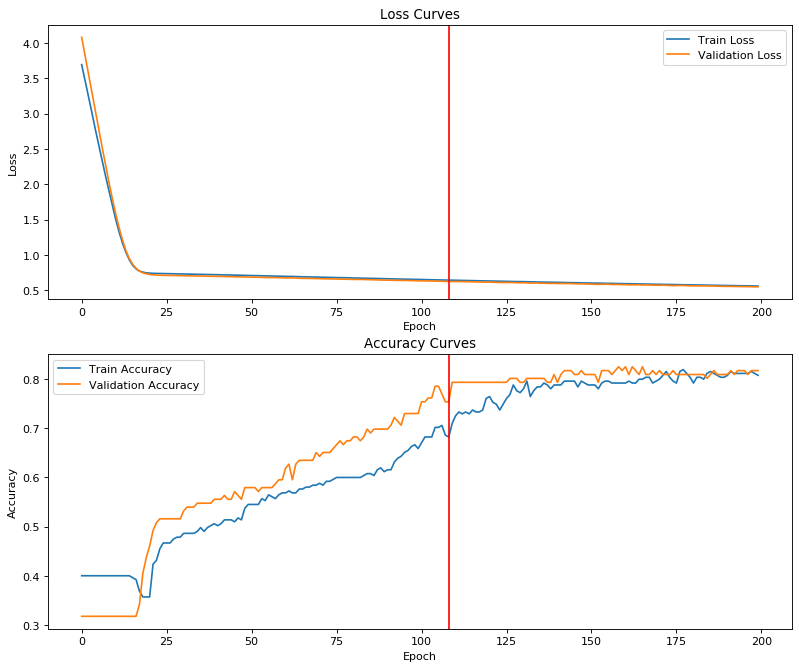

In [27]:
# plot the curve again with the epoch index that indicates the start of the overfitting period highlighted in red
plot_learning_curve_over_epochs(history, early_stopping = early_stopping)

### ILV04.4 Parameterization of a Final Model Using the Insights Gained in Previous Sections


In [44]:
model = create_model(input_dim=X_train.shape[1],
                     output_dim=1,
                     hidden_nodes=10)

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='auto')

history = model.fit(X_train, y_train, validation_split = 0.33, 
                       verbose=0, epochs=200, batch_size=32,
                       callbacks=[early_stop])

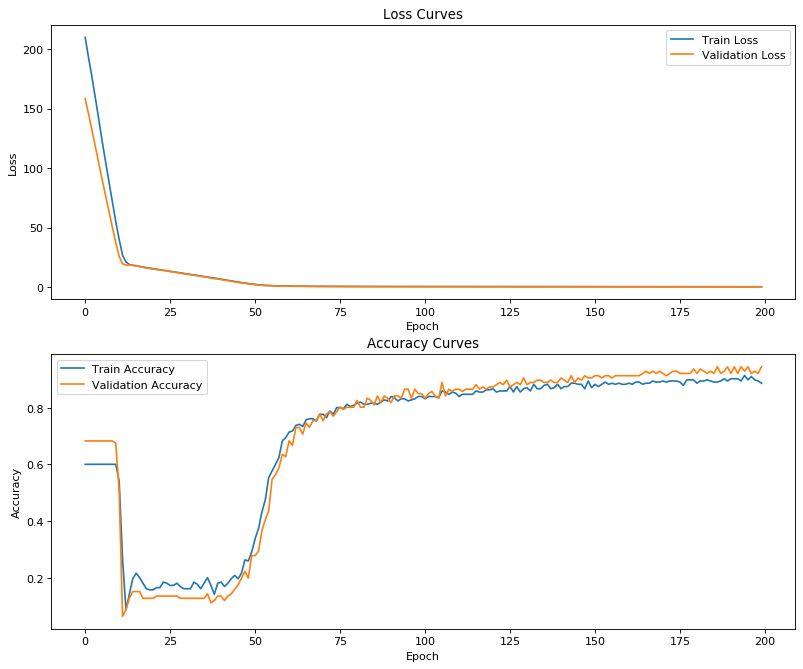

In [48]:
plot_learning_curve_over_epochs(history)

In [45]:
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

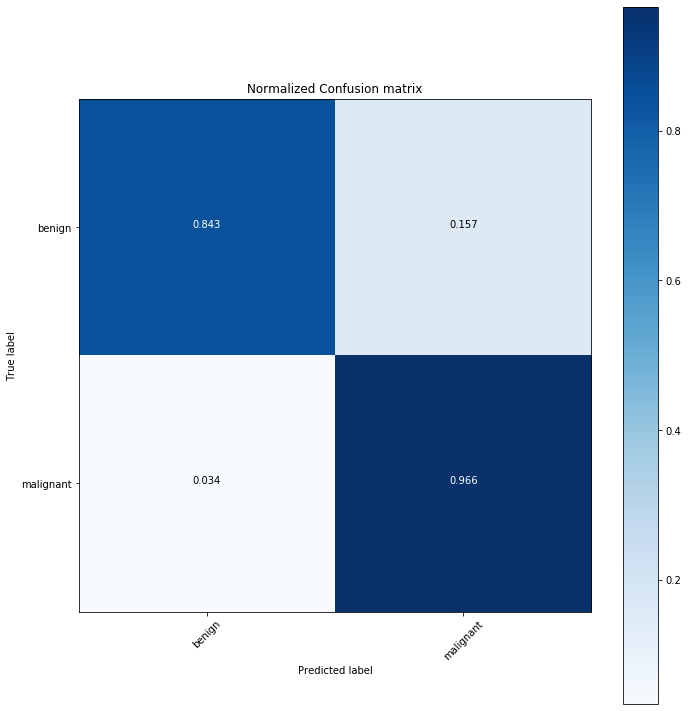

In [46]:
cm = confusion_matrix(y_test, y_pred)

class_names = ['benign', 'malignant']

plot_confusion_matrix(cm, class_names,
                          normalize=True,
                          title='Normalized Confusion matrix',
                          cmap=plt.cm.Blues)